# 3. Building network and training

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import datetime

2023-03-10 16:06:11.234887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 16:06:22.016202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 16:06:22.016341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 16:06:22.016360: W 

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
print(physical_devices)

Num GPUs: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import boto3
from boto3 import session
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [4]:
s3_client.download_file(bucket_name, 'rhods/tmp/X_train.npy', '/tmp/X_train.npy')
s3_client.download_file(bucket_name, 'rhods/tmp/y_train.npy', '/tmp/y_train.npy')
s3_client.download_file(bucket_name, 'rhods/tmp/X_val.npy', '/tmp/X_val.npy')
s3_client.download_file(bucket_name, 'rhods/tmp/y_val.npy', '/tmp/y_val.npy')
s3_client.download_file(bucket_name, 'rhods/tmp/X_test.npy', '/tmp/X_test.npy')

In [5]:
X_train = np.load('/tmp/X_train.npy')
y_train = np.load('/tmp/y_train.npy')
X_val = np.load('/tmp/X_val.npy')
y_val = np.load('/tmp/y_val.npy')
X_test = np.load('/tmp/X_test.npy')

> <div class="alert alert-block alert-info">
<b>ConvBlocks in this network will follow the LeNet design as shown above, with a few additions including Batch normalization and dropout to keep network speeds running optimally and reduce the chances of network overfitting. </b>
    <br></br>
    <b>You can find more on LeNet's here: https://en.wikipedia.org/wiki/LeNet</b></div>

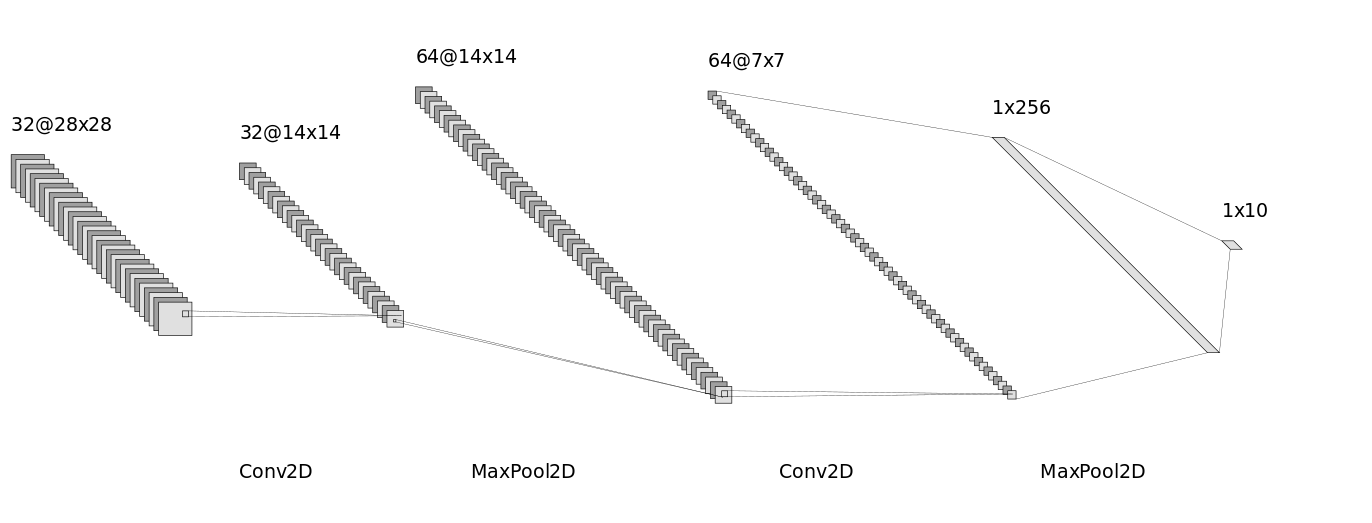

> <div class="alert alert-block alert-info">
<b>The above figure shows the best parameter combination I found after experimenting with a few variations. One thing to keep in mind when experiementing with CNN's is that increasing filters throughout the layers tends to be best.</b>
</div>

###  2.6 Custom f1, recall and precision metrics

> <div class="alert alert-block alert-info">
<b>We will now create some custom metrics, to help aid us in evaluating model performance. F1-score, Recall and precision are not pre-defined metrics avaliable in keras, which is why we have to manually create them ourselves.</b></div>

> <div class="alert alert-block alert-info">
<b>Using Keras backend, we have now defined the following metric functions; precision, recall and f1. (Epsilon is used to avoid infinite value error caused by division of zero).</b></div>

In [6]:
from keras import backend as K

In [7]:
# Precision (using keras backend)
def precision_metric(y_true, y_pred):
    threshold = 0.5  # Training threshold 0.5
    y_pred_y = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    false_negatives = K.sum(K.clip(y_true * (1-y_pred), 0, 1))
    false_positives = K.sum(K.clip((1-y_true) * y_pred, 0, 1))
    true_negatives = K.sum(K.clip((1 - y_true) * (1-y_pred), 0, 1))

    precision = true_positives / (true_positives + false_positives + K.epsilon())
    return precision

# Recall (using keras backend)
def recall_metric(y_true, y_pred):
    threshold = 0.5 #Training threshold 0.5
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    false_negatives = K.sum(K.clip(y_true * (1-y_pred), 0, 1))
    false_positives = K.sum(K.clip((1-y_true) * y_pred, 0, 1))
    true_negatives = K.sum(K.clip((1 - y_true) * (1-y_pred), 0, 1))

    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    return recall

# F1-score (using keras backend)
def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (recall+precision+K.epsilon()))
    return f1


### 3.1 Building network

In [8]:
def build_model():
    inp = keras.Input(shape=(28,28,1), name="input_1")
    x = keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),padding='SAME', 
                              activation='relu')(inp)
    x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(5,5), padding='SAME', activation='relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inp, outputs=output)

    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', f1_metric, recall_metric, precision_metric])

    return model, inp, output

> <div class="alert alert-block alert-info">
    <b>The model is built and compiled using categorical crossentropy and adam optimizer.</b>
</div>

In [9]:
model, inp, out = build_model()
model.summary()

2023-03-10 16:06:32.198126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 16:06:34.653666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15548 MB memory:  -> device: 0, name: Tesla P6, pci bus id: 0000:5c:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264 

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### 3.2 Training network

> <div class="alert alert-block alert-info">
    <b>Ok, we've built the network. Now, let's train it.</b>
</div>

In [11]:
batch_size=32

In [12]:
log_dir = "./tmp/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=batch_size,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10, 
                                                             min_delta=0.005, restore_best_weights=True),
                              keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3),
                              tensorboard_callback])

Epoch 1/40


2023-03-10 16:06:37.205440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-10 16:06:39.326124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 16:06:46.932743: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe77001e2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 16:06:46.932805: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla P6, Compute Capability 6.1
2023-03-10 16:06:47.066670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-10 16:06:47.610222: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster us

1182/1182 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8574 - f1_metric: 0.8111 - recall_metric: 0.8249 - precision_metric: 0.7988

2023-03-10 16:06:55.526659: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192675840 exceeds 10% of free system memory.


1182/1182 [==============================] - 20s 6ms/step - loss: 0.4570 - accuracy: 0.8574 - f1_metric: 0.8111 - recall_metric: 0.8249 - precision_metric: 0.7988 - val_loss: 0.1230 - val_accuracy: 0.9631 - val_f1_metric: 0.9481 - val_recall_metric: 0.9560 - val_precision_metric: 0.9406 - lr: 1.0000e-04
Epoch 2/40
1171/1182 [============================>.] - ETA: 0s - loss: 0.1471 - accuracy: 0.9540 - f1_metric: 0.9391 - recall_metric: 0.9481 - precision_metric: 0.9304

2023-03-10 16:07:01.274846: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192675840 exceeds 10% of free system memory.


1182/1182 [==============================] - 6s 5ms/step - loss: 0.1469 - accuracy: 0.9541 - f1_metric: 0.9392 - recall_metric: 0.9482 - precision_metric: 0.9305 - val_loss: 0.0670 - val_accuracy: 0.9795 - val_f1_metric: 0.9732 - val_recall_metric: 0.9777 - val_precision_metric: 0.9688 - lr: 1.0000e-04
Epoch 3/40
1181/1182 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.9685 - f1_metric: 0.9586 - recall_metric: 0.9648 - precision_metric: 0.9525

2023-03-10 16:07:07.169374: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192675840 exceeds 10% of free system memory.


1182/1182 [==============================] - 6s 5ms/step - loss: 0.1009 - accuracy: 0.9685 - f1_metric: 0.9586 - recall_metric: 0.9649 - precision_metric: 0.9525 - val_loss: 0.0585 - val_accuracy: 0.9814 - val_f1_metric: 0.9774 - val_recall_metric: 0.9808 - val_precision_metric: 0.9740 - lr: 1.0000e-04
Epoch 4/40
1174/1182 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9756 - f1_metric: 0.9681 - recall_metric: 0.9728 - precision_metric: 0.9635

2023-03-10 16:07:12.970023: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192675840 exceeds 10% of free system memory.


1182/1182 [==============================] - 6s 5ms/step - loss: 0.0759 - accuracy: 0.9756 - f1_metric: 0.9682 - recall_metric: 0.9728 - precision_metric: 0.9637 - val_loss: 0.0550 - val_accuracy: 0.9850 - val_f1_metric: 0.9816 - val_recall_metric: 0.9846 - val_precision_metric: 0.9786 - lr: 1.0000e-04
Epoch 5/40
1171/1182 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.9800 - f1_metric: 0.9741 - recall_metric: 0.9782 - precision_metric: 0.9701

2023-03-10 16:07:18.968503: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192675840 exceeds 10% of free system memory.


1182/1182 [==============================] - 6s 5ms/step - loss: 0.0641 - accuracy: 0.9800 - f1_metric: 0.9742 - recall_metric: 0.9783 - precision_metric: 0.9702 - val_loss: 0.0540 - val_accuracy: 0.9852 - val_f1_metric: 0.9816 - val_recall_metric: 0.9844 - val_precision_metric: 0.9789 - lr: 1.0000e-04
Epoch 6/40
1182/1182 [==============================] - 6s 5ms/step - loss: 0.0592 - accuracy: 0.9808 - f1_metric: 0.9755 - recall_metric: 0.9794 - precision_metric: 0.9718 - val_loss: 0.0472 - val_accuracy: 0.9857 - val_f1_metric: 0.9827 - val_recall_metric: 0.9846 - val_precision_metric: 0.9808 - lr: 1.0000e-04
Epoch 7/40
1182/1182 [==============================] - 6s 5ms/step - loss: 0.0491 - accuracy: 0.9842 - f1_metric: 0.9794 - recall_metric: 0.9826 - precision_metric: 0.9763 - val_loss: 0.0437 - val_accuracy: 0.9869 - val_f1_metric: 0.9853 - val_recall_metric: 0.9865 - val_precision_metric: 0.9842 - lr: 1.0000e-04
Epoch 8/40
1182/1182 [==============================] - 6s 5ms/ste

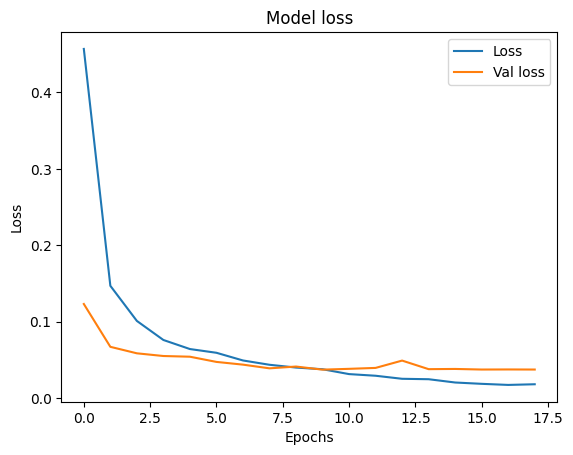

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss','Val loss'])

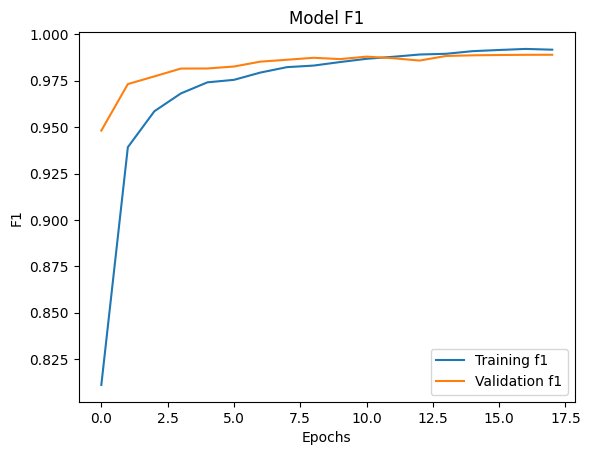

In [15]:
plt.plot(history.history['f1_metric'])
plt.plot(history.history['val_f1_metric'])
plt.title('Model F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(['Training f1','Validation f1'])

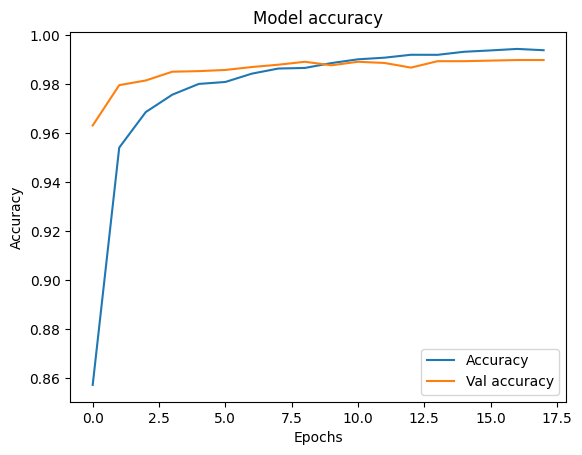

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy','Val accuracy'])

> <div class="alert alert-block alert-info">
    <b>Looking at the loss plots, the network is converging well.</b>
</div>

### 3.3 Validation results

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_pred

132/132 [==============================] - 0s 2ms/step


array([6, 2, 7, ..., 3, 1, 5])

Text(50.722222222222214, 0.5, 'True')

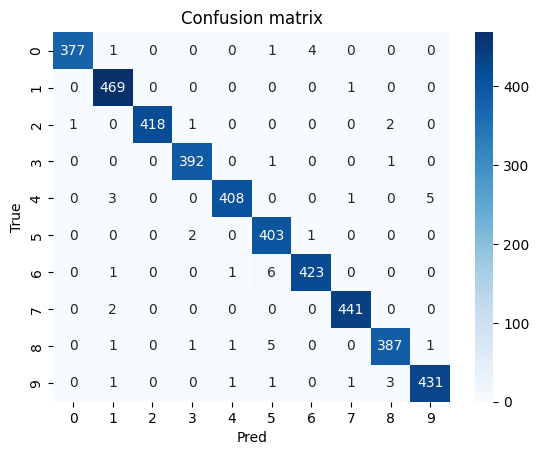

In [19]:
cm = confusion_matrix(np.argmax(y_val,axis=1), y_val_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Pred')
plt.ylabel('True')

> <div class="alert alert-block alert-info">
<b>Confusion matrix looks really good as well, lots of predictions along the diagonal which is what we want to see.</b>
</div>

In [20]:
y_val_true = np.argmax(y_val,axis=1)
y_val_true

array([6, 2, 7, ..., 3, 1, 5])

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val_true, y_val_pred)

0.9878571428571429

> <div class="alert alert-block alert-info">
<b>Ok, not bad for our first model! The model has done a pretty good job at classifying each class and is obtaining a high accuracy score. Now we should take a look at the examples the model is misclassifying.</b>
</div>

In [22]:
y_test_pred = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred,axis=1)
test_results = pd.DataFrame({'ImageID': np.arange(1,28001,1), 'Label': y_test_pred})

875/875 [==============================] - 1s 2ms/step


In [23]:
tf.saved_model.save(model, "/tmp/saved_model")

INFO:tensorflow:Assets written to: /tmp/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_model/assets


In [24]:
!python -m tf2onnx.convert --saved-model /tmp/saved_model --output /tmp/model.onnx --opset 13

2023-03-10 16:08:46.051812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 16:08:47.261392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 16:08:47.261502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 16:08:47.261516: W 

In [25]:
import boto3
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [26]:
s3_client.upload_file("/tmp/model.onnx", bucket_name, "onnx/model-v2.onnx")

In [27]:
! tar -czvf logs.tar.gz ./tmp/

./tmp/
./tmp/logs/
./tmp/logs/fit/
./tmp/logs/fit/20230310-160635/
./tmp/logs/fit/20230310-160635/validation/
./tmp/logs/fit/20230310-160635/validation/events.out.tfevents.1678464414.notebook-0.3272.1.v2
./tmp/logs/fit/20230310-160635/train/
./tmp/logs/fit/20230310-160635/train/events.out.tfevents.1678464395.notebook-0.3272.0.v2


### 3.4 Review of incorrectly classified examples

> <div class="alert alert-block alert-info">
<b>The class with the most confusions is between class 4 and 9 (this may change in your local version), let's take a look at the incorrectly predicted examples.</b>
</div>

In [28]:
cm_index = cm
np.fill_diagonal(cm_index,0)
cm_index = np.where(cm_index==cm_index.max())
if len(cm_index)>1:
    cm_index = [cm_index[0][0],cm_index[1][0]]
cm_index

[6, 5]

In [29]:
cm_index

[6, 5]

In [30]:
nine_incorrect_examples = X_val[(y_val_true==cm_index[0]) & (y_val_pred==cm_index[1])]
nine_incorrect_examples = nine_incorrect_examples.reshape(-1,28,28)

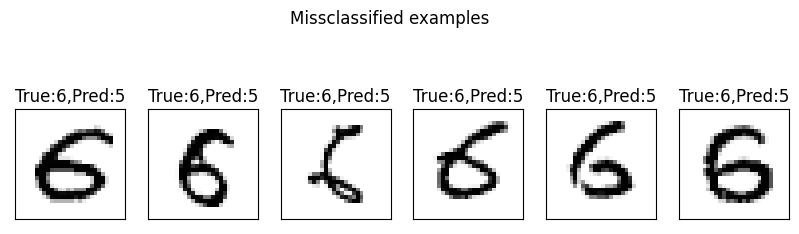

In [31]:
filters_layer_1 = model.layers[1].get_weights()[0]
filters_layer_1 = np.squeeze(filters_layer_1).reshape(32,5,5)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Missclassified examples')
w = 10
h = 10
columns = 6
rows = 6
for i in range(columns*rows +1):
    if i==nine_incorrect_examples.shape[0]:
        break
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(nine_incorrect_examples[i], cmap='Greys')
    plt.title('True:{},Pred:{}'.format(cm_index[0],cm_index[1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

> <div class="alert alert-block alert-info">
<b>Looking at the missclassifications, its understandable why the model was unable classify these examples correctly. Some of the examples are quite ambiguous, even a human labeller would probably be unable to clearly label them with good confidence. However, it does seem that there is room for improvement for some of the examples. With the use of data augmentation and hyper-parameter tuning, we should be able to further improve performance.</b>
</div>

### 3.5 Visualizing filters and feature-maps

> <div class="alert alert-block alert-info">
<b>Before we try these additional techniques, let's take a quick look at the learnt convolutional filters and feature maps, which should give us some insight on how the network is learning.</b></div>

In [32]:
model.layers

In [33]:
model.layers[1].get_weights()[0].shape

(5, 5, 1, 32)

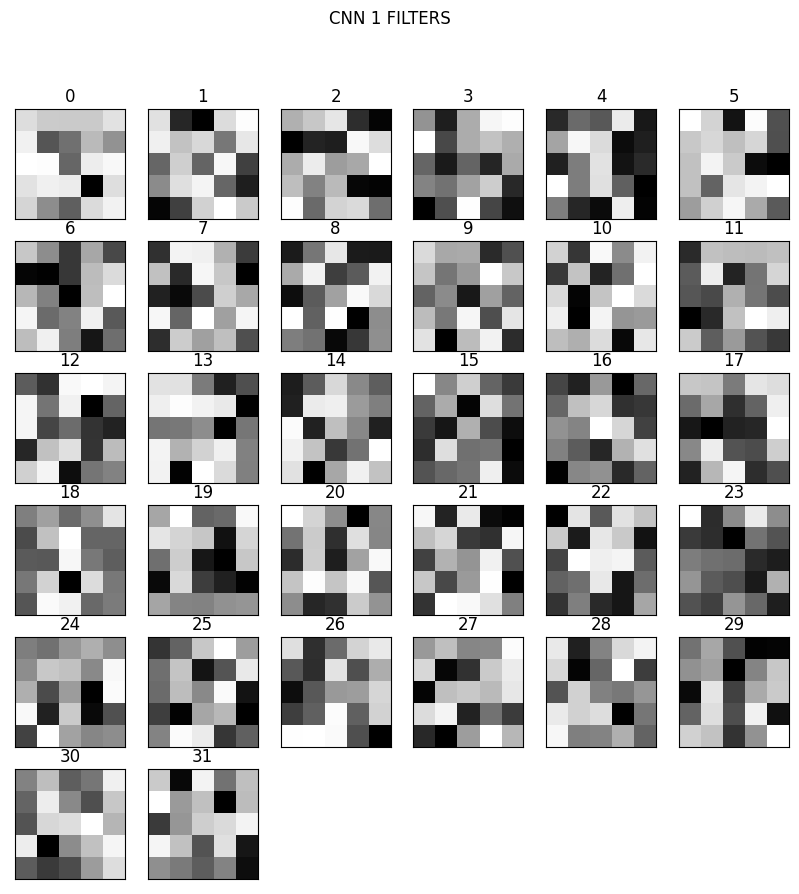

In [34]:
filters_layer_1 = model.layers[1].get_weights()[0]
filters_layer_1 = np.squeeze(filters_layer_1).reshape(32,5,5)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('CNN 1 FILTERS')
w = 10
h = 10
columns = 6
rows = 6
for i in range(columns*rows +1):
    if i==filters_layer_1.shape[0]:
        break
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(filters_layer_1[i], cmap='Greys')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
plt.show()

> <div class="alert alert-block alert-info">
<b>Shown above is the visualizatins of the 32 learnt filters in the first convolutional layer. The filters are what convolve over the images to produce the activation maps, also known as feature-maps.</b>
    <br></br>
<b>The feature-maps capture key features and patterns from the input (i.e the input image or feature maps from previous ConvBlocks).</b>
    <br></br> 
<b>The reason for visualizing feature maps is to understand what features of the input are detected and preserved in the feature maps. Lets now explore some of the feature maps to see what the model is capturing.</b>
</div>

In [35]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 conv2d (None, 28, 28, 32)
5 conv2d_1 (None, 14, 14, 64)


In [36]:


successive_outputs = [layer.output for layer in model.layers[1:]]
fm_model = keras.Model(inputs=model.input, outputs=successive_outputs)

successive_outputs


[<KerasTensor: shape=(None, 28, 28, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 14, 14, 64) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 3136) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dropout_2')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (cr

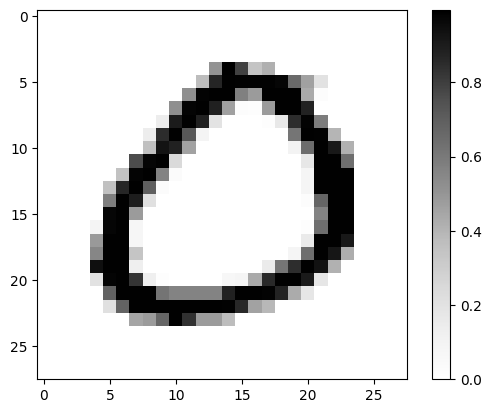

1/1 [==============================] - 0s 129ms/step


12

In [37]:
test_example = X_train[[9]]
plt.imshow(test_example[0], cmap='Greys')
plt.colorbar()
plt.show()
successive_feature_maps = fm_model.predict(test_example)
len(successive_feature_maps) # 12 for 12 layers

> <div class="alert alert-block alert-info">
<b>Now that we have a test example, lets run it through the network to obtain and visualize the feature-maps.</b></div>

(1, 28, 28, 32)
input_1
(1, 14, 14, 32)
conv2d
(1, 14, 14, 32)
max_pooling2d
(1, 14, 14, 32)
batch_normalization
(1, 14, 14, 64)
dropout
(1, 7, 7, 64)
conv2d_1
(1, 7, 7, 64)
max_pooling2d_1
(1, 7, 7, 64)
batch_normalization_1
(1, 3136)
dropout_1
(1, 256)
flatten
(1, 256)
dense
(1, 10)
dropout_2


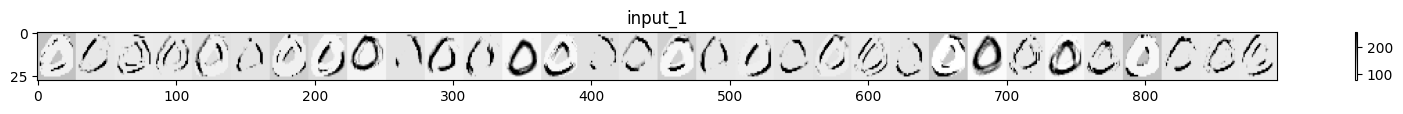

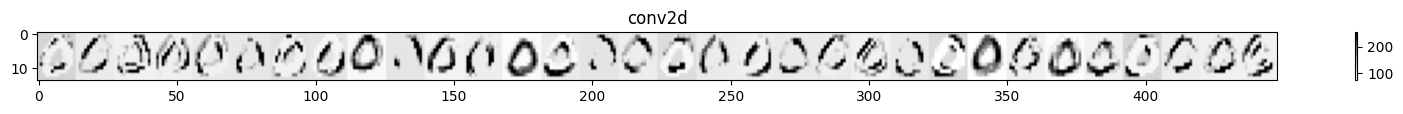

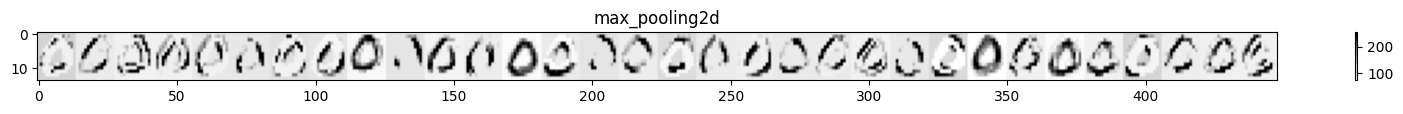

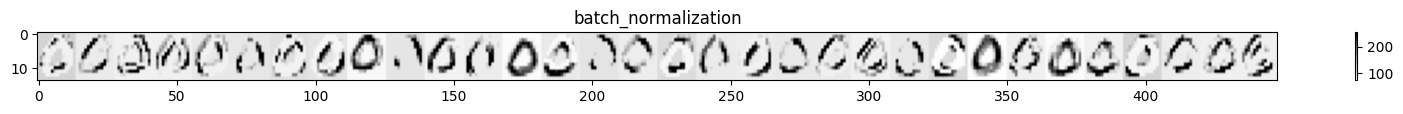

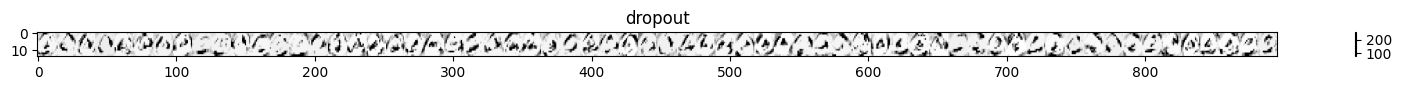

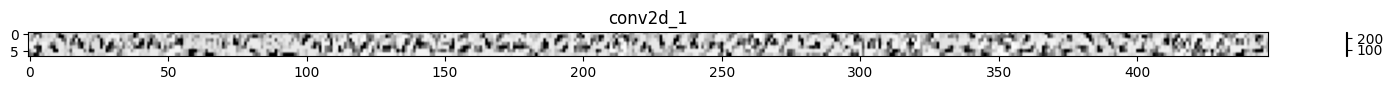

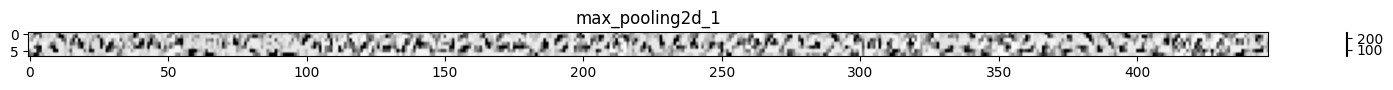

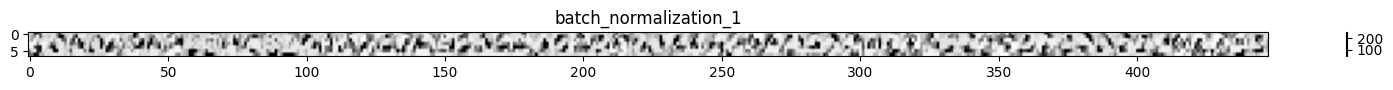

In [38]:
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    print(layer_name)
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        # Postprocess the feature to be visually palatable
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
            
        # Display the grid
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title(layer_name) 
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='Greys' )
        plt.colorbar()
        
plt.show()

> <div class="alert alert-block alert-info">
<b>Cool! We now have the feature map outputs at each layer. We can see from the outputted feature maps that some of the filters focused more on edges and outlines, while others on the overall shape and blobs.</b></div>

> <div class="alert alert-block alert-info">
    <b>For a more in-depth guides into this, check out these links:</b>
<br></br>
<b>https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks</b>
<br></br>
<b>https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c</b></div>